In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import gym

In [33]:
class ReplayBuffer():
    def __init__(self, max_size, n_states):
        self.mem_size = max_size # replay buffer size, max number of experiences to store
        self.mem_counter = 0  # replay buffer counter (used for indexing later)
        self.state_memory = np.zeros((self.mem_size, n_states), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, n_states), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_counter % self.mem_size # When memory counter goes past max replay size, it
                                                 # indexes at the start of the array
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_counter += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size) # number of experiences in replay buffer
        batch = np.random.choice(max_mem, batch_size, replace=False) # select the number of
                                                                     # experiences to train on
        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]
        return states, actions, rewards, states_, terminal

class DQNAgent():
    def __init__(self, env, lr, gamma, epsilon, batch_size, epsilon_dec=1e-3, epsilon_end=0.01, 
                 mem_size=1000000):
        self.env = env
        self.n_states = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = epsilon_dec
        self.eps_min = epsilon_end
        self.batch_size = batch_size
        self.memory = ReplayBuffer(mem_size, self.n_states)
        self.model = self.create_q_network(lr, fc1_dims=256, fc2_dims=256)
        self.target_model = self.create_q_network(lr, fc1_dims=256, fc2_dims=256)
        
    def create_q_network(self, lr, fc1_dims, fc2_dims):
        model = keras.Sequential([
            keras.layers.Dense(fc1_dims, activation='relu', input_shape=(self.n_states,)),
            keras.layers.Dense(fc2_dims, activation='relu'),
            keras.layers.Dense(self.n_actions, activation=None)])
        model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        return model

    def set_new_lr(self, lr):
        self.model.compile(optimizer=Adam(lr), loss='mean_squared_error')

    def add_to_replay_buffer(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            action = env.action_space.sample()
        else:
            observation = np.expand_dims(observation, axis=0)
            action = np.argmax(self.model.predict(observation))
            
        self.epsilon = max(self.eps_min, self.epsilon - self.eps_dec)
        return action

    def copy_across_model_weights(self):
        if self.memory.mem_counter % 100 == 0:
            weights = self.model.get_weights()
            self.target_model.set_weights(weights)
    
    def learn_from_replay_buffer(self):
        if self.memory.mem_counter < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.memory.sample_buffer(self.batch_size) 
        self.copy_across_model_weights()
        q_states = self.model.predict(states)
        q_next_states = self.target_model.predict(next_states)
        q_states[range(len(q_states)), actions] = (rewards + self.gamma 
                                                   * np.max(q_next_states, axis=1) 
                                                   * (1 - dones)) # state is terminal with no value
       
        self.model.train_on_batch(states, q_states)

In [34]:
tf.compat.v1.disable_eager_execution()

# env_name = 'CartPole-v0' #DONE
# env_name = 'MountainCar-v0' #DONE
# env_name = 'MountainCarContinuous-v0'
# env_name = 'Acrobot-v1' # DONE
# env_name = 'Pendulum-v0' #DONE
env_name = 'LunarLander-v2' #Done
env = gym.make(env_name)

lr = 0.0005
agent = DQNAgent(env=env, gamma=0.99, epsilon=1.0, lr=lr, mem_size=1000000, batch_size=64,
                 epsilon_dec=1e-4, epsilon_end=0)

In [18]:
highscores = []
epsilons = []

n_games = 500
for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()

    while not done:       
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        #reward += (abs(next_observation[0]) + 0.3)**2 / 100 # Mountain car exploration
        agent.add_to_replay_buffer(observation, action, reward, next_observation, done)
        agent.learn_from_replay_buffer()
        observation = next_observation
        score += reward
        
    epsilons.append(agent.epsilon)
    highscores.append(score)

    avg_score = np.mean(highscores[-100:])
    print('episode:', i, 'score:', round(score, 2), 'average_score:', round(avg_score),
          'epsilon:', round(agent.epsilon, 2))

episode: 0 score: -270.14 average_score: -270 epsilon: 0.99
episode: 1 score: -235.51 average_score: -253 epsilon: 0.98
episode: 2 score: -125.26 average_score: -210 epsilon: 0.97
episode: 3 score: -320.51 average_score: -238 epsilon: 0.96
episode: 4 score: -91.06 average_score: -208 epsilon: 0.95
episode: 5 score: -241.76 average_score: -214 epsilon: 0.94
episode: 6 score: -113.89 average_score: -200 epsilon: 0.93
episode: 7 score: -119.06 average_score: -190 epsilon: 0.92
episode: 8 score: -154.34 average_score: -186 epsilon: 0.91
episode: 9 score: -69.15 average_score: -174 epsilon: 0.91
episode: 10 score: -96.08 average_score: -167 epsilon: 0.9
episode: 11 score: -301.45 average_score: -178 epsilon: 0.89
episode: 12 score: -243.64 average_score: -183 epsilon: 0.88
episode: 13 score: -285.68 average_score: -191 epsilon: 0.86
episode: 14 score: -95.89 average_score: -184 epsilon: 0.85
episode: 15 score: -228.97 average_score: -187 epsilon: 0.83
episode: 16 score: -145.37 average_scor

episode: 143 score: 264.58 average_score: 115 epsilon: 0
episode: 144 score: 248.42 average_score: 115 epsilon: 0
episode: 145 score: 308.53 average_score: 120 epsilon: 0
episode: 146 score: 271.89 average_score: 123 epsilon: 0
episode: 147 score: 247.2 average_score: 127 epsilon: 0
episode: 148 score: 262.45 average_score: 131 epsilon: 0
episode: 149 score: 254.26 average_score: 135 epsilon: 0
episode: 150 score: 240.05 average_score: 139 epsilon: 0
episode: 151 score: 268.04 average_score: 144 epsilon: 0
episode: 152 score: 239.03 average_score: 145 epsilon: 0
episode: 153 score: 267.46 average_score: 149 epsilon: 0
episode: 154 score: 248.16 average_score: 153 epsilon: 0
episode: 155 score: 213.55 average_score: 156 epsilon: 0
episode: 156 score: 217.6 average_score: 159 epsilon: 0
episode: 157 score: 273.92 average_score: 164 epsilon: 0
episode: 158 score: 2.67 average_score: 164 epsilon: 0
episode: 159 score: 271.68 average_score: 165 epsilon: 0
episode: 160 score: 265.31 average_

episode: 287 score: 234.51 average_score: 191 epsilon: 0
episode: 288 score: 240.6 average_score: 190 epsilon: 0
episode: 289 score: 231.76 average_score: 190 epsilon: 0
episode: 290 score: 285.21 average_score: 190 epsilon: 0
episode: 291 score: 206.41 average_score: 190 epsilon: 0
episode: 292 score: 276.73 average_score: 190 epsilon: 0
episode: 293 score: 235.4 average_score: 190 epsilon: 0
episode: 294 score: 268.81 average_score: 190 epsilon: 0
episode: 295 score: -50.25 average_score: 189 epsilon: 0
episode: 296 score: 271.6 average_score: 190 epsilon: 0
episode: 297 score: 257.45 average_score: 190 epsilon: 0
episode: 298 score: 238.85 average_score: 193 epsilon: 0
episode: 299 score: 228.19 average_score: 192 epsilon: 0
episode: 300 score: 269.89 average_score: 195 epsilon: 0
episode: 301 score: 245.07 average_score: 200 epsilon: 0
episode: 302 score: 224.89 average_score: 199 epsilon: 0
episode: 303 score: 189.36 average_score: 198 epsilon: 0
episode: 304 score: -324.56 averag

episode: 431 score: 217.05 average_score: 191 epsilon: 0
episode: 432 score: 285.69 average_score: 193 epsilon: 0
episode: 433 score: 212.18 average_score: 193 epsilon: 0
episode: 434 score: 161.87 average_score: 195 epsilon: 0
episode: 435 score: 260.54 average_score: 195 epsilon: 0
episode: 436 score: 264.43 average_score: 195 epsilon: 0
episode: 437 score: 218.92 average_score: 195 epsilon: 0
episode: 438 score: 221.1 average_score: 195 epsilon: 0
episode: 439 score: 243.91 average_score: 195 epsilon: 0
episode: 440 score: 250.43 average_score: 195 epsilon: 0
episode: 441 score: 239.51 average_score: 195 epsilon: 0
episode: 442 score: 241.72 average_score: 195 epsilon: 0
episode: 443 score: 257.36 average_score: 195 epsilon: 0
episode: 444 score: 264.19 average_score: 195 epsilon: 0
episode: 445 score: 100.02 average_score: 196 epsilon: 0
episode: 446 score: 261.71 average_score: 196 epsilon: 0
episode: 447 score: 199.35 average_score: 195 epsilon: 0
episode: 448 score: 255.98 avera

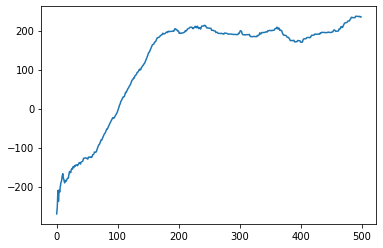

In [19]:
pd.Series(highscores).rolling(window=100, min_periods=1).mean().plot()

In [65]:
test_highscores = []

for i in range(1):
    done = False
    score = 0
    observation = env.reset()
    
    while not done:
        env.render()
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        observation = next_observation
        score += reward
        
    test_highscores.append(score)
    
env.close()
test_highscores

[-363.1842377869482]